# SAL (sensitivity adjustment learning) の実装

$$
s(U; w) = \sqrt{\sum_i^m(\frac{\partial o}{\partial x_i})^2} = f'(U)\sqrt{\sum_i^mw_i^2}
$$

上記の値を 1.0 まで持っていけるような感じにする。

必要モジュールの import

In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable

In [2]:
class ReservoirLayer(nn.Module):
    """reservoir layer with SAL"""
    def __init__(
        self, 
        input_dim:int=100,
        output_dim:int=100,
        act_func:str="tanh"
    ):
        super(ReservoirLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        if act_func == "tanh":
            self.act = torch.tanh
            self.inv_act = lambda u,o: 1 - o ** 2
        else:
            raise ValueError("Invalid function type '%s' only valid on '%s'"% (act_func, "tanh"))
        
    def forward(self, x):
        u = self.linear(x)
        x = self.act(u)
        s_each_w = self.inv_act(u,x) * torch.sqrt(torch.sum(self.linear.weight ** 2, dim=1))
        sensitivity = torch.mean(s_each_w)
        return x, sensitivity      
    
    
class Reservoir(nn.Module):
    """reservoir with SAL"""
    def __init__(
        self, 
        dims:List[int]=[100, 100], 
        beta:float=0.99,  # sensitivity を計算するときの移動平均の度合い
        leaky_rate:float=0.8  # どれぐらいの比率で前ステップの状態を持っておくか
    ):
        super(Reservoir, self).__init__()
        assert dims[0] == dims[-1], \
            "The first and end values of dims should be the same but different %f vs %f" % (
            dims[0], dims[-1])
        layers = []
        for i in range(len(dims) - 1):
            layers.append(
                ReservoirLayer(dims[i], dims[i+1], act_func="tanh")
            )
        self.layers = layers
        self.n_layers = len(layers)
        self.beta = beta
        self.leaky_rate = leaky_rate
        self.dims = dims

    def forward(self, x, prev_states:List[torch.Tensor], prev_s:torch.Tensor=0.0):
        sensitivity_list = torch.empty(self.n_layers)
        states = []
        for i, layer in enumerate(self.layers):
            _x, _s = layer(x)
            x = _x
#             x = self.leaky_rate * prev_states[i] + (1 - self.leaky_rate) * _x
            states.append(x)
            sensitivity_list[i] = _s
        s = torch.mean(sensitivity_list)
        s_bar = self.beta * prev_s + (1 - self.beta) * s
        return x, s_bar, states

    @property
    def states_array(self):
        return [
            state.to('cpu').detach().numpy().copy() for state in self._states
        ]
    @property
    def states(self):
        return self._states
    
    def generate_init_state(self):
        return [
            Variable(torch.Tensor(np.random.randn(dim))) for dim in self.dims[1:]
        ]

In [3]:
res = Reservoir(dims=[100, 100], beta=0.99)

In [4]:
sample_input = torch.Tensor(np.random.randn(100))
init_states = res.generate_init_state()
res(sample_input, init_states)

(tensor([-0.2098,  0.2756,  0.0675, -0.4448,  0.2559, -0.1804,  0.4552, -0.1112,
          0.1812, -0.1507, -0.0102, -0.1862,  0.0936,  0.0643,  0.5044,  0.4491,
          0.0863,  0.2553, -0.1337, -0.3051, -0.2013,  0.7553, -0.2608, -0.1541,
         -0.7478, -0.0241,  0.1942, -0.0640, -0.6656,  0.6042, -0.4368, -0.2825,
          0.5864, -0.2653, -0.3096,  0.1112, -0.7098, -0.1395,  0.5053,  0.9073,
         -0.0212,  0.5864, -0.1933, -0.2697, -0.6733, -0.0830, -0.4087,  0.6939,
          0.3884, -0.0599,  0.2387, -0.1309, -0.5859, -0.7505,  0.3008, -0.4924,
         -0.5425, -0.3708, -0.4428, -0.1847, -0.5989, -0.5016,  0.5612, -0.3192,
          0.5278, -0.0435,  0.0148,  0.3081, -0.5196,  0.6403,  0.0417, -0.1070,
          0.0660, -0.7494, -0.2947,  0.1112, -0.4551, -0.3450,  0.3342, -0.0623,
         -0.4445, -0.3169, -0.1466,  0.6121,  0.4373,  0.7502,  0.0437,  0.5738,
         -0.1128,  0.2992, -0.7044, -0.5022,  0.3057, -0.4837, -0.3105,  0.0077,
         -0.4263,  0.3072, -

In [5]:
# TODO: ここから、サイン波のものを使ってリザバーを SAL にそって学習させてみる

In [22]:
def check_chaoticity(res):
    input_signal = np.sin(np.linspace(0, 100, 1000)) + np.cos(np.linspace(0, 30, 1000))
    input_signal = input_signal[800:]
    x = torch.Tensor(np.random.randn(net_size).astype(np.float32))
    x02 = x.clone()
    s_bar = 0
    state_list = []
    state = res.generate_init_state()
    for i in range(len(input_signal)):
        x = x + torch.Tensor(np.dot(input_signal[i], w_in).flatten())
        x, s_bar, state = res(x, state, prev_s=s_bar)
        state_list.append(state)

    s_bar = 0
    state_list02 = []
    state = res.generate_init_state()
    x = x02 + 1e-4
    for i in range(len(input_signal)):
        x = x + torch.Tensor(np.dot(input_signal[i], w_in).flatten())
        x, s_bar, state = res(x, state, prev_s=s_bar)
        state_list02.append(state)
    state01 = np.concatenate([state[0].detach().numpy().reshape(-1, 1) for state in state_list], axis=1)
    state02 = np.concatenate([state[0].detach().numpy().reshape(-1, 1) for state in state_list02], axis=1)

    diff = np.mean(np.abs(state01 - state02) ** 2, axis=0)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.title("Difference between two states")
    plt.plot(np.log10(diff))
    
    plt.subplot(2, 1, 2)
    plt.title("The same element of state sequences")
    plt.plot(state01[0], alpha=0.5, label="not perturbated")
    plt.plot(state02[0], alpha=0.5, label="perturbated")
    plt.legend()
    
    plt.tight_layout()

In [23]:
net_size = 100
input_signal = np.sin(np.linspace(0, 100, 1000)) + np.cos(np.linspace(0, 30, 1000))
input_signal = input_signal.astype(np.float32)
input_scale = 0.5

w_in = (np.random.rand(1, net_size) - 0.5) * input_scale
w_in = w_in.astype(np.float32)

In [24]:
res = Reservoir(dims=[net_size, net_size], beta=0.99, leaky_rate=0.0)

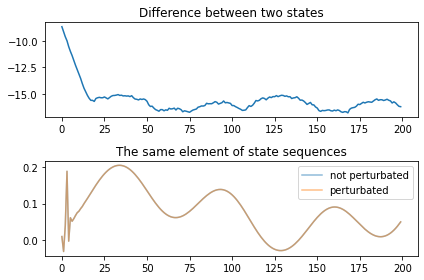

In [25]:
check_chaoticity(res)

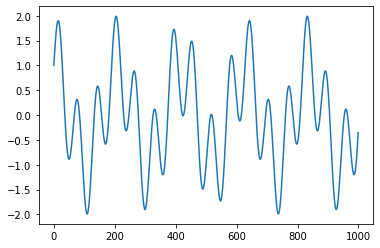

In [26]:
plt.plot(input_signal)

In [27]:
x = torch.Tensor(np.random.randn(net_size).astype(np.float32))
s_bar = 0
state_list = []
state = res.generate_init_state()
for i in range(len(input_signal)):
    x = x + torch.Tensor(np.dot(input_signal[i], w_in).flatten())
    x, s_bar, state = res(x, state, prev_s=s_bar)
    state_list.append(state)

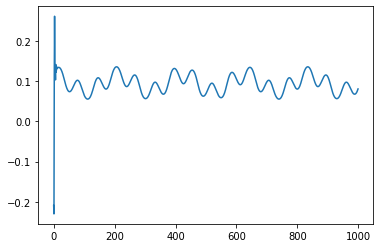

In [28]:
plt.plot([state[0][1] for state in state_list])

In [37]:
train_signal = input_signal[:100]
valid_signal = input_signal[100:]

parameters = []
for layer in res.layers:
    parameters += layer.parameters()
optimizer = SGD(parameters, lr=1.0, weight_decay=0.01)

In [38]:
num_epochs = 100
state_list = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x = Variable(torch.Tensor(np.random.randn(net_size)))
    s_bar = 0
    state = res.generate_init_state()
    for idx in range(len(train_signal)):
        step_input = Variable(torch.Tensor([train_signal[idx]]))
        x = x + torch.Tensor(np.dot(step_input, w_in).flatten())
        x, s_bar, state = res(x, state, prev_s=s_bar)
        state_list.append(state)
    if s_bar.to('cpu').detach().numpy().copy() < 1.0:
        loss = - s_bar
        loss.backward(retain_graph=True)
        optimizer.step()
    else:
        break
    print(s_bar)

tensor(0.9943, grad_fn=<AddBackward0>)
tensor(0.9948, grad_fn=<AddBackward0>)
tensor(0.9952, grad_fn=<AddBackward0>)
tensor(0.9840, grad_fn=<AddBackward0>)
tensor(0.9701, grad_fn=<AddBackward0>)
tensor(0.4316, grad_fn=<AddBackward0>)
tensor(0.1839, grad_fn=<AddBackward0>)
tensor(0.1568, grad_fn=<AddBackward0>)
tensor(0.1125, grad_fn=<AddBackward0>)
tensor(0.1162, grad_fn=<AddBackward0>)
tensor(0.1633, grad_fn=<AddBackward0>)
tensor(0.1541, grad_fn=<AddBackward0>)
tensor(0.0900, grad_fn=<AddBackward0>)
tensor(0.1292, grad_fn=<AddBackward0>)
tensor(0.1626, grad_fn=<AddBackward0>)
tensor(0.2009, grad_fn=<AddBackward0>)
tensor(0.1540, grad_fn=<AddBackward0>)
tensor(0.1524, grad_fn=<AddBackward0>)
tensor(0.1977, grad_fn=<AddBackward0>)
tensor(0.1888, grad_fn=<AddBackward0>)
tensor(0.1908, grad_fn=<AddBackward0>)
tensor(0.1670, grad_fn=<AddBackward0>)
tensor(0.2241, grad_fn=<AddBackward0>)
tensor(0.1975, grad_fn=<AddBackward0>)
tensor(0.1399, grad_fn=<AddBackward0>)
tensor(0.1755, grad_fn=<A

KeyboardInterrupt: 

/Users/oharasoh/reservoir/mic_input/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


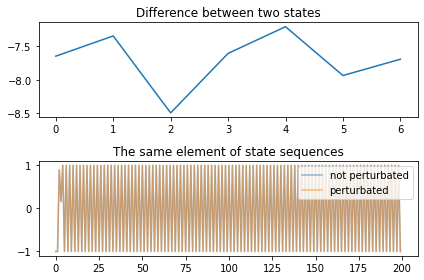

In [39]:
check_chaoticity(res)